In [1]:
from preprocessing import *
from clustering import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from GMM import my_GMM_uniform_cluster
data_contrats = pd.read_csv('train_contrats_approx.csv',sep=",")
from sklearn.metrics import adjusted_rand_score
from collections import Counter
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15,5]

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def preprocessing(data, balance=True, train_size=0.5):
    import pandas as pd
    if balance : 
      data_non_nul=data[data.nombre_de_sinistre>0]
      data_nul=data[data.nombre_de_sinistre==0]
      data_nul_1,data_nul_2=train_test_split(data_nul,train_size=len(data_non_nul)/len(data_nul))
      data_clustering=pd.concat([data_non_nul,data_nul_1])
    else :
      data_clustering = data.copy()
    columns_conduc=["Classe_Age_Situ_Cont","Type_Apporteur","Activite"]
    columns_contrat=["Mode_gestion","Zone","Fractionnement","franchise","FORMULE",'Exposition_au_risque']
    #columns_vehi=["Age_du_vehicule","ValeurPuissance","Freq_sinistre"]
    columns_vehi=["Age_du_vehicule","ValeurPuissance"]
    data_clustering=data_clustering[columns_conduc+columns_contrat+columns_vehi]
    data_clustering.loc[:,"Classe_Age_Situ_Cont"]=data_clustering["Classe_Age_Situ_Cont"].apply(classe_age)
    data_clustering.loc[:,"franchise"]=data_clustering["franchise"].apply(franchise_)
    data_clustering.loc[:,["Type_Apporteur","Activite","Zone","FORMULE"]] = data_clustering[["Type_Apporteur","Activite","Zone","FORMULE"]].astype('str')
    data_clustering_d=pd.get_dummies(data_clustering)
    #data_scaled = normalize(data_clustering_d, axis=0)
    data_scaled = data_clustering_d

    data_scaled = pd.DataFrame(data_scaled, columns=data_clustering_d.columns)
    #data_scaled["Freq_sinistre"] = data["Freq_sinistre"]

    if train_size < 1 :
        train_data,test_data = train_test_split(data_scaled,train_size=train_size)
    else :
        train_data,test_data = data_scaled, None
    return train_data,test_data

Le but est ici d'évaluer la stabilité de differentes méthodes de clustering, en utilisant le procédé suivant : 
Clustering sur un jeu d'entrainement (75%) (Clustering A)
Nouveau clustering sur toute la base de données, ie 75% initaux + 25% restants (Clustering B)
Calcul du adjusted rand index, qui est d'autant plus grand que deux points dans un même cluster dan le clustering A sont toutjours dans le même cluster dans le clustering B, ou que deux points dans deux clusters différents dans le clustering A sont toutjours dans deux clusters différents dans le clustering B.
Lors du calcul du score, seuls 75% des points sont donc considérés.
Selon nous, une perturbation de 25% est forte, et permettera de vraiment mettre les méthodes de clustering à l'épreuve.

In [4]:
data = pd.read_csv("train_contrats_approx.csv", sep=";", engine="python")

# For original database ---
#data = pd.read_csv("train_contrats.csv", sep=";")
#data["Freq_sinistre"] = data["nombre_de_sinistre"]/data["Exposition_au_risque"]

#train_data, _ = preprocessing(data, balance=False, train_size=0.75)
preprocessing(data, balance=False, train_size=1.)[0]
data = preprocessing(data, balance=False, train_size=1.)[0]
train_data = data[:(int(len(data)*0.75))]

In [5]:
train_data

,Classe_Age_Situ_Cont,franchise,Exposition_au_risque,ValeurPuissance,Type_Apporteur_1,Type_Apporteur_2,Type_Apporteur_3,Activite_1,Activite_2,Activite_3,...,Zone_6,Fractionnement_A,Fractionnement_S,Fractionnement_T,FORMULE_2,FORMULE_3,FORMULE_4,FORMULE_5,Age_du_vehicule_<= 5 ans,Age_du_vehicule_> 5 ans
0,6,3,0.55,7,1,0,0,0,0,1,...,0,1,0,0,0,0,0,1,1,0
1,5,2,0.41,7,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
2,5,2,0.23,7,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
3,5,2,0.26,4,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
4,6,2,0.24,4,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65416,1,3,1.00,8,1,0,0,0,0,1,...,0,0,0,1,0,1,0,0,1,0
65417,1,3,0.94,8,1,0,0,0,0,1,...,0,0,0,1,0,1,0,0,1,0
65418,2,3,1.00,8,1,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,1
65419,2,3,1.00,7,1,0,0,0,0,1,...,0,0,0,1,0,1,0,0,1,0


#### Adjusted rand index

Pour avoir une baseline et mieux intepreter l'ARI, il est calculé ici pour un clustering **aléatoire**, pour un nombre de point à peu près égal à celui de notre base de données. L'ARI devrait dans ce cas valoir 0.

In [0]:
ari = 0
for i in range(100):
  clust_A = np.random.randint(low=0, high=4, size=65000)
  clust_B = np.random.randint(low=0, high=4, size=65000)
  ari += adjusted_rand_score(clust_A,clust_B)/100

In [0]:
print(ari)

8.920638121083689e-07


### KMeans

Essayons avec 5 clusters pour commencer !

Train data

In [10]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(train_data)
train_labels=kmeans.labels_

In [11]:
train_labels

array([0, 0, 0, ..., 2, 2, 2])

All data

In [7]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(data)
labels=kmeans.labels_

In [12]:
labels = labels[:len(train_labels)]

In [13]:
adjusted_rand_score(labels,train_labels)

0.4878356299000678

Attention la cellule suivante nécessite 30mn-1h pour s'executer

In [27]:
from sklearn.metrics import davies_bouldin_score

ari=[]
dis=[]
dbs = []

for n_clusters in range(1,10):
    
    dis_i = []      
    ari_i = []
    dbs_i = []

    for i in range(20):
      
        kmeans_train = KMeans(n_clusters=n_clusters).fit(train_data)
        train_labels=kmeans_train.labels_

        kmeans = KMeans(n_clusters=n_clusters).fit(data)
        labels=kmeans.labels_
        labels_ = labels[:len(train_labels)]

        ari_i.append(adjusted_rand_score(labels_,train_labels)) 
        dis_i.append(kmeans.inertia_)
        
        if n_clusters> 1:
            dbs_i.append( davies_bouldin_score(data, labels))   
            
    print(f"{n_clusters} clusters : ARI = {np.mean(ari_i)}")
    ari.append(ari_i)
    dis.append(dis_i)
    dbs.append(dbs_i)

1 clusters : ARI = 1.0
2 clusters : ARI = 0.9957095416882826
3 clusters : ARI = 0.7181868382878802
4 clusters : ARI = 0.6917198763969132
5 clusters : ARI = 0.5163027089608961
6 clusters : ARI = 0.60164239897506
7 clusters : ARI = 0.6661546340142964
8 clusters : ARI = 0.6448067104785361
9 clusters : ARI = 0.6714684289958418


Text(0, 0.5, 'ARI')

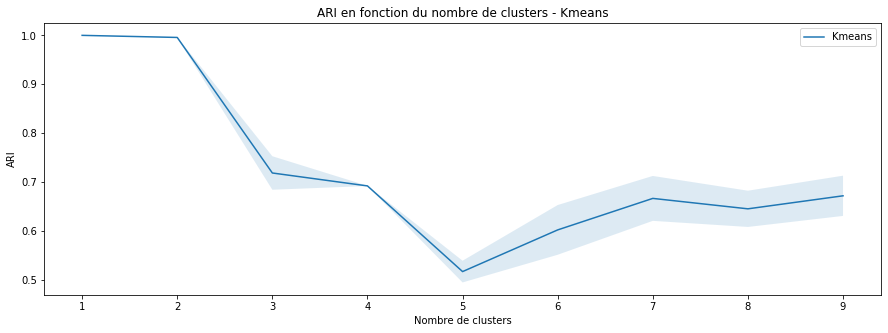

In [42]:
data_ari = np.array(ari)
T, n_rep = data_ari.shape
mean_ari = np.mean(data_ari, axis=1)
std_ari = np.std(data_ari, axis=1) / np.sqrt(n_rep)
t = np.arange(1,T+1)
plt.plot(t, mean_ari, label="Kmeans")
plt.fill_between(t, mean_ari - 2 * std_ari, mean_ari + 2 * std_ari, alpha=0.15)
plt.legend()
plt.title("ARI en fonction du nombre de clusters - Kmeans")
plt.xlabel("Nombre de clusters")
plt.ylabel("ARI")

Text(0, 0.5, 'DBS')

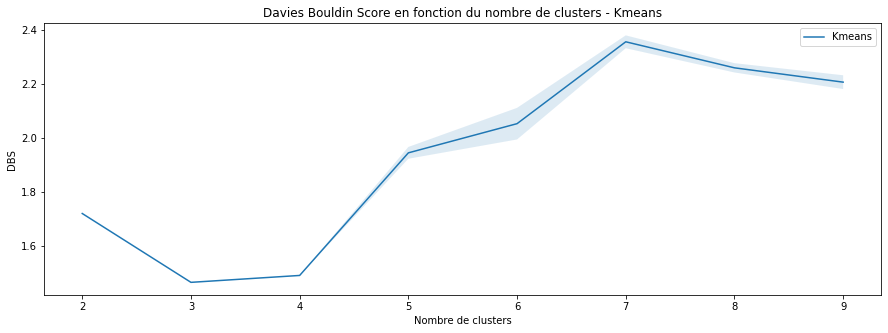

In [50]:
data_ari = np.array(dbs)
T, n_rep = data_ari.shape
mean_ari = np.mean(data_ari, axis=1)
std_ari = np.std(data_ari, axis=1) / np.sqrt(n_rep)
t = np.arange(2,T+2)
plt.plot(t, mean_ari, label="Kmeans")
plt.fill_between(t, mean_ari - 2 * std_ari, mean_ari + 2 * std_ari, alpha=0.15)
plt.legend()

plt.title("Davies Bouldin Score en fonction du nombre de clusters - Kmeans")
plt.xlabel("Nombre de clusters")
plt.ylabel("DBS")

Text(0, 0.5, 'Distorsion')

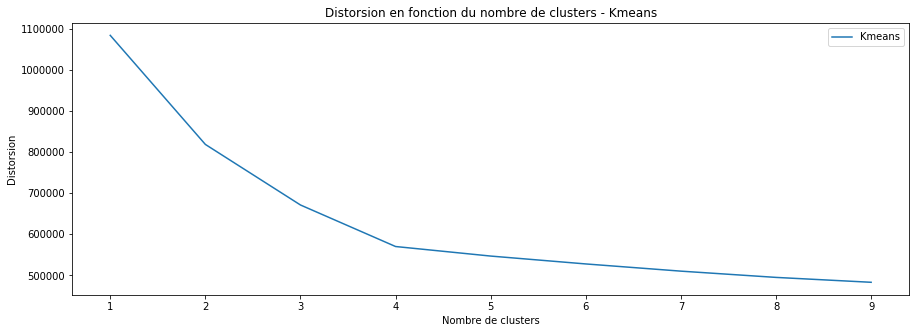

In [49]:
data_ari = np.array(dis)
T, n_rep = data_ari.shape
mean_ari = np.mean(data_ari, axis=1)
std_ari = np.std(data_ari, axis=1) / np.sqrt(n_rep)
t = np.arange(1,T+1)
plt.plot(t, mean_ari, label="Kmeans")
plt.fill_between(t, mean_ari - 2 * std_ari, mean_ari + 2 * std_ari, alpha=0.15)
plt.legend()
plt.title("Distorsion en fonction du nombre de clusters - Kmeans")
plt.xlabel("Nombre de clusters")
plt.ylabel("Distorsion")

#### Profil moyen de chaque cluster

Dans ce cas, le nombre de clusters idéal est débattable. Nous avons choisi 4 selon la elbow methode (voir figure ci-dessus).

In [91]:
kmeans = KMeans(n_clusters=4).fit(data)
labels=kmeans.labels_

In [92]:
data["cluster"] = labels
count = Counter(labels)
#print(count)
data_group = data.groupby('cluster').mean()
data_group

,Classe_Age_Situ_Cont,franchise,Exposition_au_risque,ValeurPuissance,Type_Apporteur_1,Type_Apporteur_2,Type_Apporteur_3,Activite_1,Activite_2,Activite_3,...,Zone_6,Fractionnement_A,Fractionnement_S,Fractionnement_T,FORMULE_2,FORMULE_3,FORMULE_4,FORMULE_5,Age_du_vehicule_<= 5 ans,Age_du_vehicule_> 5 ans
cluster,,,,,,,,,,,,,,,,,,,,,
0,5.209534,2.857891,0.403617,7.846554,0.768778,0.182306,0.048916,0.251192,0.016448,0.160103,...,0.009749,0.343612,0.251364,0.405025,0.000429,0.786901,0.049732,0.162938,0.711746,0.288254
1,1.884546,2.663850,0.485088,4.299549,0.642802,0.243973,0.113225,0.225776,0.044585,0.214060,...,0.012131,0.303852,0.239048,0.457100,0.000622,0.781171,0.113121,0.105086,0.634714,0.365286
2,1.832515,3.157751,0.467847,7.753129,0.640695,0.278323,0.080982,0.242127,0.014560,0.172147,...,0.008589,0.297669,0.230143,0.472188,0.000082,0.814519,0.081063,0.104335,0.729939,0.270061
3,5.199762,2.447139,0.413002,4.365571,0.790438,0.141853,0.067709,0.223174,0.060087,0.208424,...,0.010938,0.371709,0.248218,0.380073,0.000445,0.738913,0.068848,0.191794,0.584290,0.415710


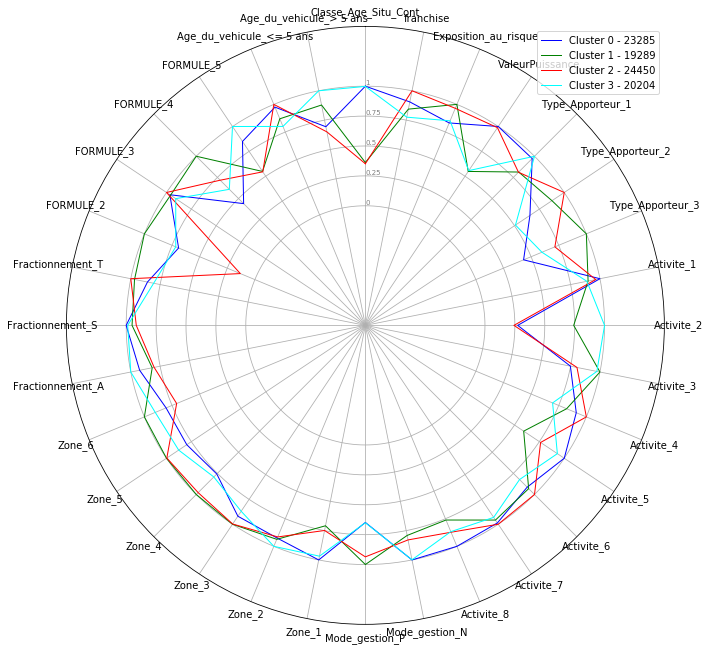

In [93]:
# ------- PART 1: Create background
from math import pi

#df = data_group.drop("cluster", axis=1)
df =(data_group)/(data_group.max())
categories=list(df)
N = 32
 
fig = plt.figure(figsize=(11,11))
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0,0.25,0.5,0.75,1], ["0","0.25","0.5","0.75","1"], color="grey", size=7)
plt.ylim(-1,1.5)

colors = ["blue", "green", "red", "cyan", "magenta", "yellow", "black", "orange", "slategray"]
for i in range(len(df)):
    
    values=df.loc[i].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=f"Cluster {i} - {count[i]}",color=colors[i])
    #ax.fill(angles, values, color=colors[i], alpha=0.05)
plt.legend(loc="best")

On observe tout d'abord que les clusters sont de tailles très homogènes. On remarque que dans tous les clusters, la moyenne de chaque variables est presque la même (hormis pour activité 2 et FORMULE_2). Les variables étant soit continues, soit binaires, cela montre que dans chaque cluster, la présence d'une catégorie d'une variable (initiale) est la même, et les variables continues prennent des valeurs moyennes très proches. Cela reflète une mauvaise séparation des points en sous groupes.